In [76]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

# Third model 
### (inspired by pytorch API)

## Creating the API:

In [77]:
''' Represents a linear layer '''
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / (fan_in**0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

''' Represents a batch normalization layer '''
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

''' Represents the hyperpoblic tangent function '''   
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

### Getting data information:

In [78]:
''' Get information about the dataset '''
words = open('names.txt', 'r').read().splitlines()
random.shuffle(words)
print('First 8 words in file:\n', words[:8])
print('\nTotal words in file: ', len(words))

First 8 words in file:
 ['jamarri', 'amour', 'manil', 'anahi', 'alida', 'athira', 'koda', 'maryiah']

Total words in file:  32033


### Creating useful mappings:

In [79]:

''' Create mappings between characters and integers '''
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

print('\nMapping string to integer: ', stoi)
print('Mapping integer to string: ', itos)

vocab_size = 27


Mapping string to integer:  {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
Mapping integer to string:  {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Building the dataset:

In [80]:
''' Building the dataset '''
# Takes in a list of names and an int which determines 
# how many previous chars are used for the prediction.
# Returns the inputs (X) and labels (Y) of the dataset
def build_dataset(words, block_size):
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

### Creating the training and testing datasets:

In [81]:
''' Creating the train and test datasets '''
split = 0.9 # percentage of the words used to train the model
block_size = 6 # amount of characters used for the prediction
words_train = round(split * len(words))

x_train, y_train = build_dataset(words[:words_train], block_size)
x_test, y_test = build_dataset(words[words_train:], block_size)

## Initializing the model:

In [82]:
g = torch.Generator().manual_seed(2147483647) # for determistic results

features = 10 # dimensionaly of the character feature vectors
neurons = 100 # neurons in the hidden layer

''' Creating a 6 layer MLP '''
C = torch.randn((vocab_size, features), generator=g)
layers = [
    Linear(block_size * features, neurons), BatchNorm1d(neurons), Tanh(),
    Linear(              neurons, neurons), BatchNorm1d(neurons), Tanh(),
    Linear(              neurons, neurons), BatchNorm1d(neurons), Tanh(),
    Linear(              neurons, neurons), BatchNorm1d(neurons), Tanh(),
    Linear(              neurons, neurons), BatchNorm1d(neurons), Tanh(),
    Linear(           neurons, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    layers[-1].gamma *= 0.1 # initialize with a more uniform distribution
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # multiply by the proper gain for a tanh function

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print("Total parameters: ", sum(p.nelement() for p in parameters)) # print total parameters
for p in parameters:
    p.requires_grad = True

Total parameters:  50551


## Training the model:

In [83]:
epochs = 400000
batch_size = 32
lossi = []
ud = []

for i in range(1,epochs+1):

    ''' construct minibatch '''
    ix = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)
    x_batch, y_batch = x_train[ix], y_train[ix]

    ''' forward pass '''
    emb = C[x_batch] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y_batch) # loss function

    ''' backward pass '''
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < epochs * 0.66 else 0.01 # defining the learning rate
    for p in parameters:
        p.data -= lr * p.grad
    
    ''' tracking information '''
    if i == 1: print(i, "/", epochs, ": ", loss.item())
    if i % 10000 == 0: print(i, "/", epochs, ": ", loss.item())
    lossi.append(loss.item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

1 / 400000 :  3.288133144378662
10000 / 400000 :  2.4090611934661865
20000 / 400000 :  2.5262138843536377
30000 / 400000 :  1.9228733777999878
40000 / 400000 :  2.078784704208374
50000 / 400000 :  2.0663464069366455
60000 / 400000 :  2.226747751235962
70000 / 400000 :  1.997774600982666
80000 / 400000 :  2.318425416946411
90000 / 400000 :  1.9911022186279297
100000 / 400000 :  1.7732293605804443
110000 / 400000 :  2.184706687927246
120000 / 400000 :  2.3063161373138428
130000 / 400000 :  2.2782280445098877
140000 / 400000 :  1.7203214168548584
150000 / 400000 :  2.037637233734131
160000 / 400000 :  1.9913126230239868
170000 / 400000 :  1.8785637617111206
180000 / 400000 :  1.590929627418518
190000 / 400000 :  2.0346240997314453
200000 / 400000 :  1.9450993537902832
210000 / 400000 :  1.650904655456543
220000 / 400000 :  1.7818479537963867
230000 / 400000 :  1.9928566217422485
240000 / 400000 :  1.9562242031097412
250000 / 400000 :  2.3938865661621094
260000 / 400000 :  2.16767692565917

## Visualizing training information:

layer 2 (      Tanh): mean -0.01, std 0.69, saturated: 15.88%
layer 5 (      Tanh): mean +0.02, std 0.75, saturated: 20.97%
layer 8 (      Tanh): mean -0.01, std 0.77, saturated: 23.38%
layer 11 (      Tanh): mean -0.03, std 0.80, saturated: 26.72%
layer 14 (      Tanh): mean +0.04, std 0.80, saturated: 29.12%


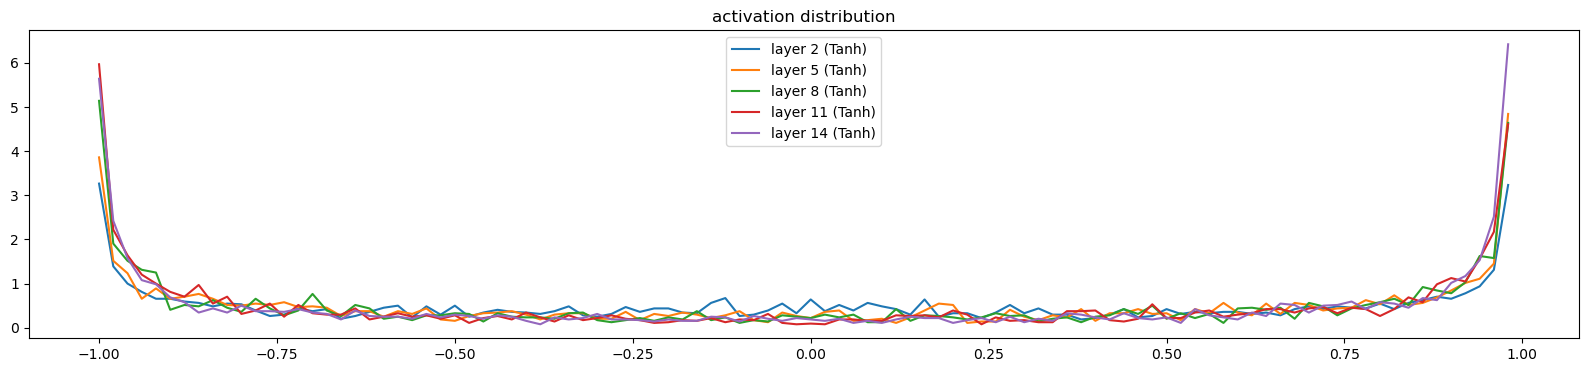

In [84]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution');

layer 2 (      Tanh): mean +0.000000, std 5.789565e-03
layer 5 (      Tanh): mean +0.000000, std 5.145352e-03
layer 8 (      Tanh): mean +0.000000, std 4.332335e-03
layer 11 (      Tanh): mean -0.000000, std 3.975254e-03
layer 14 (      Tanh): mean +0.000000, std 4.482697e-03


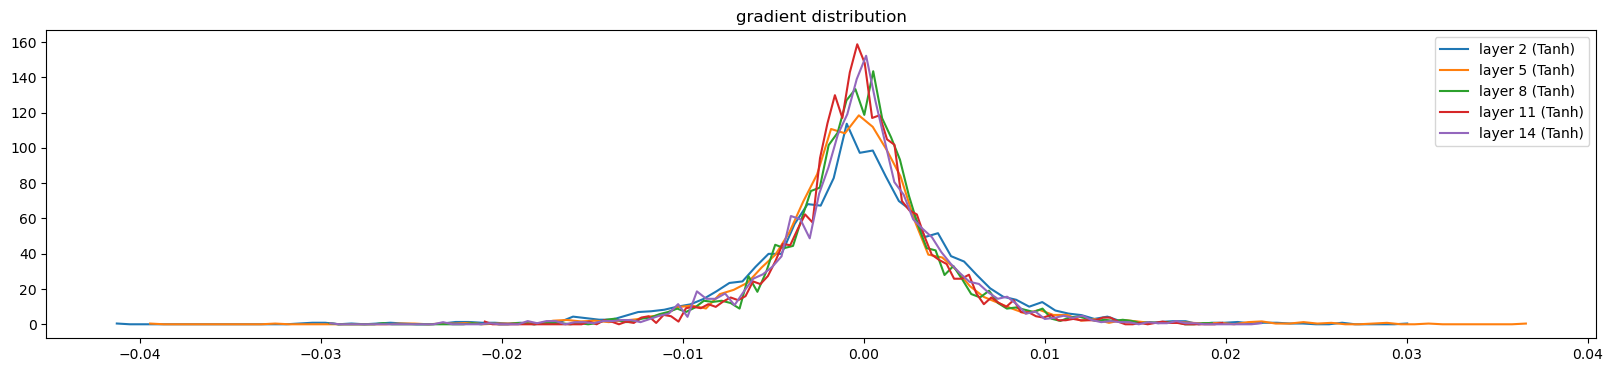

In [85]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution');

weight   (27, 10) | mean +0.000000 | std 1.913510e-02 | grad:data ratio 1.425488e-02
weight  (60, 100) | mean +0.000046 | std 7.041126e-03 | grad:data ratio 1.548239e-02
weight (100, 100) | mean -0.000005 | std 6.227055e-03 | grad:data ratio 1.748776e-02
weight (100, 100) | mean -0.000142 | std 5.933933e-03 | grad:data ratio 1.711692e-02
weight (100, 100) | mean -0.000040 | std 5.098104e-03 | grad:data ratio 1.553183e-02
weight (100, 100) | mean -0.000039 | std 4.706635e-03 | grad:data ratio 1.517250e-02
weight  (100, 27) | mean +0.000111 | std 7.761756e-03 | grad:data ratio 1.642945e-02


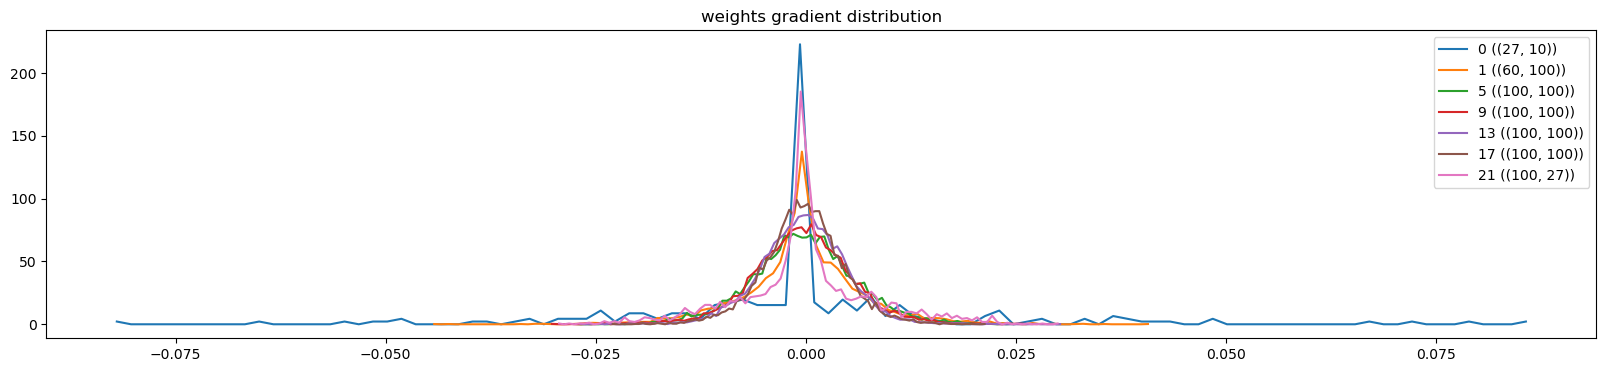

In [86]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        t = p.grad
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} ({tuple(p.shape)})')
plt.legend(legends)
plt.title('weights gradient distribution');

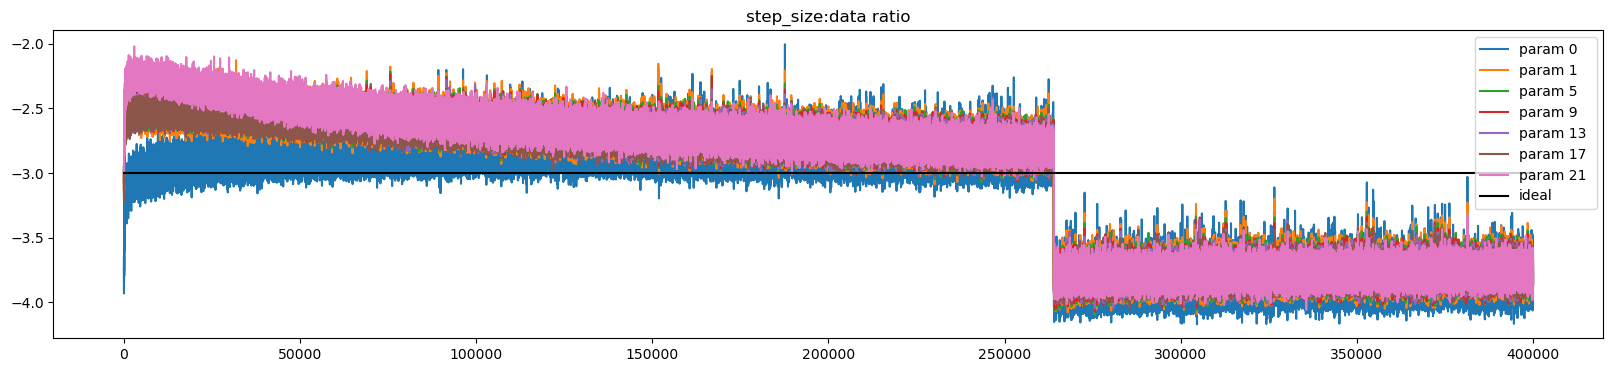

In [87]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d ' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
legends.append('ideal')
plt.legend(legends)
plt.title('step_size:data ratio');

## The model's loss:

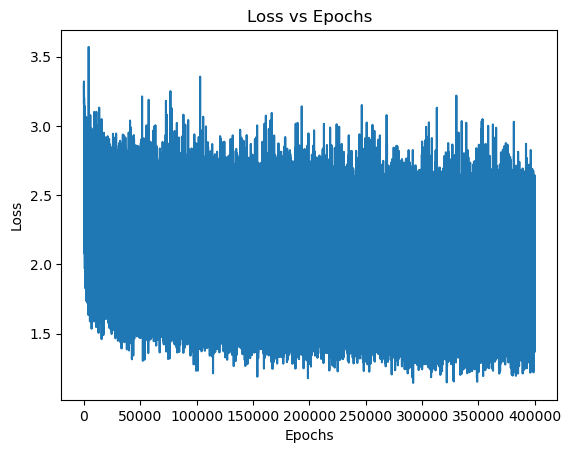

In [88]:
plt.plot(range(len(lossi)),lossi);
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss");

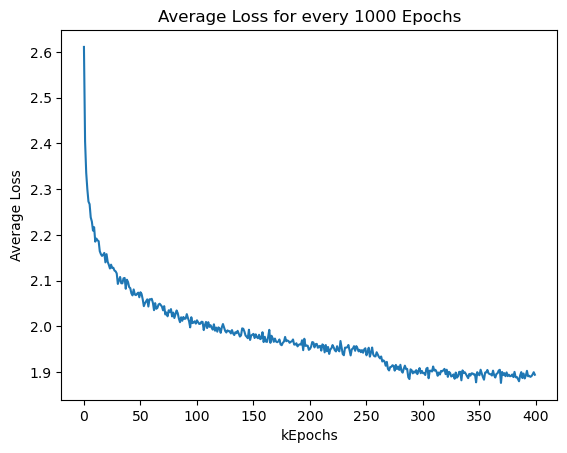

In [89]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1));
plt.title("Average Loss for every 1000 Epochs")
plt.ylabel("Average Loss")
plt.xlabel("kEpochs");

### Expected loss:

In [90]:
print('Expected loss:', -torch.tensor(1/27.0).log())

Expected loss: tensor(3.2958)


### Loss on training set:

In [91]:
print('Training set loss:', lossi[-1])

Training set loss: 1.8654797077178955


### Loss on testing set:

In [92]:
''' Tell batchnorm layers we're done training '''
for layer in layers:
    if layer.__class__.__name__ == 'BatchNorm1d':
        layer.training = False

''' Get final loss on test set '''
emb = C[x_test] # embed the characters into vectors
x = emb.view(emb.shape[0], -1)
for layer in layers:
    x = layer(x)
loss = F.cross_entropy(x, y_test) # loss function
print("Testing set loss:", loss.item())

Testing set loss: 1.9871132373809814


## Model predictions:

In [93]:
with torch.no_grad():
    for _ in range(20): # sample 20 words

        out = []
        context = [0] * block_size # inputs
        while True:

            emb = C[torch.tensor([context])] # embed the characters into vectors
            x = emb.view(1, -1)
            for layer in layers:
                x = layer(x)

            probs = F.softmax(x, dim=1)
            # Sample from probability distribution
            ix = torch.multinomial(probs, num_samples=1).item()

            context = context[1:] + [ix]
            out.append(ix)

            if ix == 0:
                break

        print(''.join(itos[i] for i in out))

avesh.
loris.
josian.
rakoyth.
breesley.
zya.
myaria.
analia.
coothukn.
antarace.
dny.
addeya.
eldin.
liuna.
alban.
hyna.
tobie.
kaychona.
carsyn.
embran.


# Second model

### Getting data information:

In [223]:
''' Get information about the dataset '''
words = open('names.txt', 'r').read().splitlines()
random.shuffle(words)
print('First 8 words in file:\n', words[:8])
print('\nTotal words in file: ', len(words))

First 8 words in file:
 ['zerek', 'zyking', 'zadiel', 'warrior', 'aerianna', 'jubal', 'dalya', 'iliyah']

Total words in file:  32033


### Creating useful mappings:

In [224]:

''' Create mappings between characters and integers '''
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

print('\nMapping string to integer: ', stoi)
print('Mapping integer to string: ', itos)


Mapping string to integer:  {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
Mapping integer to string:  {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Building the dataset:

In [225]:
''' Building the dataset '''
# Takes in a list of names and an int which determines 
# how many previous chars are used for the prediction.
# Returns the inputs (X) and labels (Y) of the dataset
def build_dataset(words, block_size):
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

### Defining model parameters:

In [226]:
def build_model(block_size, features, neurons, verbose=1):
    g = torch.Generator().manual_seed(2147483647) # for determistic results

    ''' Look up table C '''
    C = torch.randn((27, features), generator=g)

    ''' Weights and biases '''
    W1 = torch.randn((block_size * features, neurons), generator=g) * (5/3) / (block_size * features)**0.5
    #b1 = torch.randn(neurons, generator=g) * 0.01

    W2 = torch.randn((neurons, 27), generator=g) * 0.01
    b2 = torch.randn(27, generator=g) * 0

    bngain = torch.ones((1, neurons))
    bnstd = torch.ones((1, neurons))
    bnbias = torch.zeros((1, neurons))
    bnmean = torch.zeros((1, neurons))

    ''' Parameters '''
    parameters = [C, W1, W2, b2, bngain, bnbias, bnmean, bnstd]

    ''' Telling pytorch that all parameters require a gradient '''
    for p in parameters:
        p.requires_grad = True

    if verbose > 0: print('Number of parameters:', sum(p.nelement() for p in parameters))

    return parameters

### Training model function:

In [239]:

def train_model(params, inputs, labels, step_size=0.1, batch_size=50, epochs=100):
    g = torch.Generator().manual_seed(2147483647) # for determistic results

    losses, passes = [], []
    for i in range(epochs):
        ''' Paramaeters '''
        C, W1, W2, b2, bngain, bnbias, bnmean, bnstd = params[0], params[1], params[2], params[3], params[4], params[5], params[6], params[7]
        
        ''' Contructing a minibatch '''
        ix = torch.randint(0, inputs.shape[0], (batch_size,), generator=g)

        ''' Forward Pass: '''
        emb = C[inputs[ix]] # Embedding
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1 # hiddel layer pre-activation
        bnmeani = hpreact.mean(0, keepdim=True)
        bnstdi = hpreact.std(0, keepdim=True)
        hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # batch normilization
        h = torch.tanh(hpreact) # Hidden layer
        logits = h @ W2 + b2 # Logits
        loss = F.cross_entropy(logits, labels[ix]) # Loss function

        ''' Calibrate the batch normalization '''
        with torch.no_grad():
            params[6] = 0.999 * params[6] + 0.001 * bnmeani
            params[7] = 0.999 * params[7] + 0.001 * bnstdi

        ''' Backward Pass: '''
        # Reinitialize gradients
        for p in params[:6]:
            p.grad = None
        # Calculate the new gradients
        loss.backward()
        # Slightly adjust parameters against gradient direction
        #if i > epochs/2: step_size /= 10
        for p in params[:6]:
            p.data -= step_size * p.grad

        if i % 10000 == 0: print(i, '/', epochs, '---->', loss.item())
                
        losses.append(loss.item())
        passes.append(i)

    ''' Getting final lost by doing a final forward pass '''
    emb = C[inputs[ix]] # Embedding
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # hiddel layer pre-activation
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # batch normilization
    h = torch.tanh(hpreact) # Hidden layer
    logits = h @ W2 + b2 # Logits
    loss = F.cross_entropy(logits, labels[ix]) # Loss function
    
    losses.append(loss.item())
    passes.append(passes[-1] + 1)
    print(epochs, '/', epochs, '---->', loss.item())

    ''' Plot the loss progess '''
    plt.plot(passes, losses)

    return params, losses, passes

    

### Creating the training and testing datasets:

In [240]:
''' Creating the train and test datasets '''
split = 0.9 # percentage of the words used to train the model
block_size = 7 # amount of characters used for the prediction
words_train = round(split * len(words))

x_train, y_train = build_dataset(words[:words_train], block_size)
x_test, y_test = build_dataset(words[words_train:], block_size)

Number of parameters: 20497
0 / 400000 ----> 3.3043205738067627
10000 / 400000 ----> 2.6286449432373047
20000 / 400000 ----> 2.1344943046569824
30000 / 400000 ----> 2.2220749855041504
40000 / 400000 ----> 2.3599493503570557
50000 / 400000 ----> 2.475325345993042
60000 / 400000 ----> 2.166999578475952
70000 / 400000 ----> 1.9681684970855713
80000 / 400000 ----> 2.2457714080810547
90000 / 400000 ----> 1.9806832075119019
100000 / 400000 ----> 2.3839142322540283
110000 / 400000 ----> 1.9286669492721558
120000 / 400000 ----> 2.2397446632385254
130000 / 400000 ----> 2.022747755050659
140000 / 400000 ----> 2.456810712814331
150000 / 400000 ----> 2.1689188480377197
160000 / 400000 ----> 2.11003041267395
170000 / 400000 ----> 2.035383939743042
180000 / 400000 ----> 1.9956365823745728
190000 / 400000 ----> 1.9283639192581177
200000 / 400000 ----> 2.091092586517334
210000 / 400000 ----> 2.369586706161499
220000 / 400000 ----> 2.3620054721832275
230000 / 400000 ----> 1.9737153053283691
240000 / 40

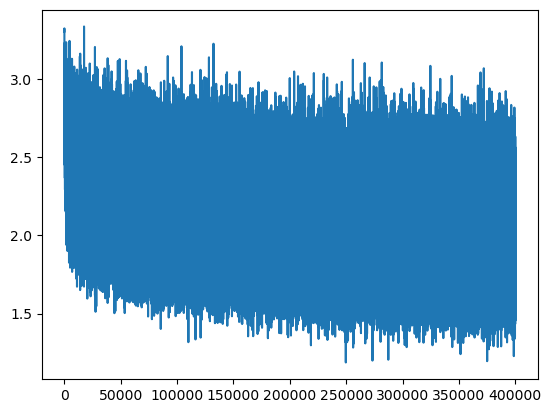

In [241]:
'''' Build model '''
features = 10
neurons = 200
model = build_model(block_size, features, neurons)

''' Train model '''
batch_size = 32
epochs = 400000
step_size = 0.01
model, losses, passes = train_model(model, x_train, y_train, step_size, batch_size, epochs)


In [242]:
#Expected loss:
-torch.tensor(1/27.0).log()

tensor(3.2958)

### Loss on test set:

In [237]:
C, W1, W2, b2, bngain, bnbias, bnmean, bnstd  = model[0], model[1], model[2], model[3], model[4], model[5], model[6], model[7]

emb = C[x_test] # Embedding
embcat = emb.view(emb.shape[0], -1)
hpreact = embcat @ W1
hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
h = torch.tanh(hpreact) # Hidden layer
logits = h @ W2 + b2 # Logits
loss = F.cross_entropy(logits, y_test) # Loss function
loss.item()

2.087782144546509

### Sampling from the model:

In [238]:
for _ in range(20): # sample 20 words

    out = []
    context = [0] * block_size # inputs
    while True:

        emb = C[torch.tensor([context])] # Embedding
        embcat = emb.view(1, -1)
        hpreact = embcat @ W1
        hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
        h = torch.tanh(hpreact) # Hidden layer
        logits = h @ W2 + b2 # Logits

        probs = F.softmax(logits, dim=1)
        # Sample from probability distribution
        ix = torch.multinomial(probs, num_samples=1).item()

        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

chemle.
jennah.
dehongau.
morlemy.
salea.
jathariah.
bajustau.
kaisa.
jaylem.
iora.
leyza.
dellex.
fitlie.
jadrianne.
sorhalie.
adhur.
aelae.
viglet.
ayvery.
lisa.


# First attempt at model

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for determistic results

''' Look up table C '''
C = torch.randn((27, 2), generator=g)

''' Weights and biases '''
W1 = torch.randn((6, 100), generator=g) # for 3 characters, 2 features per character, 100 neurons
b1 = torch.randn(100, generator=g) # for 100 neurons

W2 = torch.randn((100, 27), generator=g) #100 inputs, 27 possible character predictions
b2 = torch.randn(27, generator=g) # 27 possible character predictions

''' Parameters '''
parameters = [C, W1, b1, W2, b2]

In [ ]:
print('Number of parameters:', sum(p.nelement() for p in parameters))

Number of parameters: 3481


## Training the model:

In [329]:
''' Telling pytorch that all parameters require a gradient'''
for p in parameters:
    p.requires_grad = True

In [304]:
''' keeping track of loss in order to plot it later'''
losses = []
passes = []

### Gradient descent

In [305]:
for i in range(1000):

    ''' Contructing a minibatch '''
    ix = torch.randint(0, X.shape[0], (32,))

    ''' Forward Pass: '''
    # Embedding
    emb = C[X[ix]]
    #logits
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    #Loss
    loss = F.cross_entropy(logits, Y[ix])

    ''' Backward Pass: '''
    # Reinitialize gradients
    for p in parameters:
        p.grad = None
    # Calculate the new gradients
    loss.backward()
    # Slightly adjust parameters against gradient direction
    for p in parameters:
        p.data -= 0.1 * p.grad
            
    losses.append(loss.item())
    passes.append(i)

''' Getting final lost by doing a final forward pass '''
# Embedding
emb = C[X[ix]]
#logits
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
#Loss
loss = F.cross_entropy(logits, Y[ix])
losses.append(loss.item())
passes.append(passes[-1]+1)

### Plotting the loss

Final loss:  2.5467405319213867


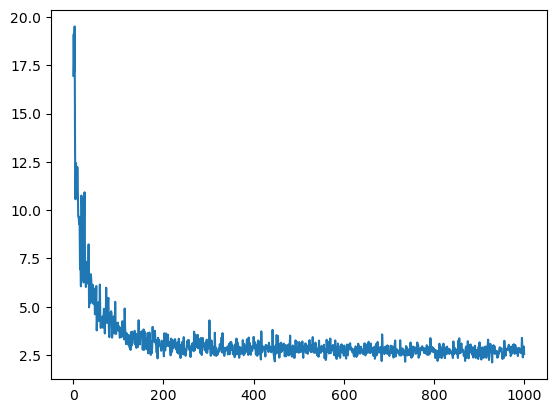

In [308]:
plt.plot(passes, losses)
print('Final loss: ', losses[-1])

## Finding optimal gradient step size
We are going to find the loss after using multiple difference learning rates and then plot the loss as a function of learning rate to find the optimal learning rate ot use

In [330]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10** lre

lrates = []
lossesTest = []

for i in range(1000):
    ''' Contructing a minibatch '''
    ix = torch.randint(0, X.shape[0], (32,))

    ''' Forward Pass: '''
    # Embedding
    emb = C[X[ix]]
    #logits
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    #Loss
    loss = F.cross_entropy(logits, Y[ix])

    ''' Backward Pass: '''
    # Reinitialize gradients
    for p in parameters:
        p.grad = None
    # Calculate the new gradients
    loss.backward()
    # Slightly adjust parameters against gradient direction
    lr = lrs[i]
    for p in parameters:
        p.data -= lr * p.grad
            
    lossesTest.append(loss.item())
    lrates.append(lre[i])

''' Getting final lost by doing a final forward pass '''
# Embedding
emb = C[X[ix]]
#logits
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
#Loss
loss = F.cross_entropy(logits, Y[ix])
lossesTest.append(loss.item())
lrates.append(lre[-1])


### Plotting the loss as a function of the learning rates exponent:

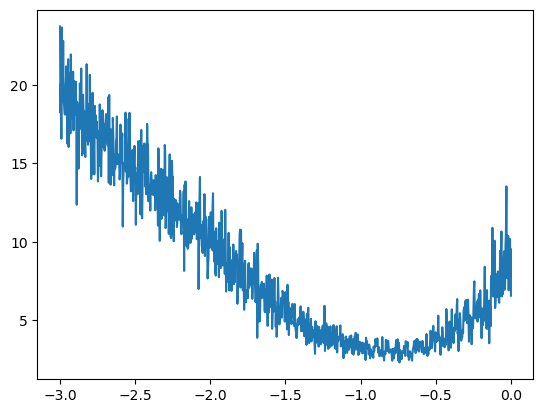

In [332]:
plt.plot(lrates, lossesTest);

So a good learning rate is between 1**-1.0 and 1**-0.5